# Research Engineer test task

Dear applicant!
We are asking you to implement a thoughtful pipeline for a rather simple toy task.

You are given the dataset from the Tiny ImageNet Challenge which is the default final project for Stanford [CS231N](http://cs231n.stanford.edu/) course. It runs similar to the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/2014/) (ILSVRC). The goal of the original challenge is for you to do as well as possible on the Image Classification problem.

Although your goal of this task is **not** just to do as good as possible on the Image Classification problem.
We would rather encourage you to demonstrate best practices and your skills of rapid prototyping reliable pipelines.
You may want to take a look at Andrej Karpathy's [Recipe for Training Neural Networks
](https://karpathy.github.io/2019/04/25/recipe/).

We provided you with a simple pytorch baseline. You are free to use it or to design the whole solution from scratch. 
We are not restricting you with the frameworks, you can install any package you need and organise your files however you want. Just please make sure to provide all the sources, checkpoints, logs, visualisations etc.
If you decide to use our platform setup, it is all already taken care of. We will just review the artifacts of your work on our storage. Otherwise it is your responsibility.

To add some measurable results to the task, your final goal will be to achieve best accuracy on the provided __test__ split of the Tiny ImageNet dataset.
Also you are expected to show all the visualisations you find necessary alongside with the final evaluation metrics. We already took care of a tensorboard setup for you, so you can track some of your plots there. Please follow  [README.md](https://github.com/neuromation/test-task/blob/master/README.md) for instructions. 


# Table of contents:
- [Preparing the data](#Preparing-the-data)
- [Training model](#Training-model)
- [Visualizing results](#Visualizing-results)
- [Testing the solution](#Testing-the-solution)

In [1]:
import os
import shutil
import csv
import zipfile
import urllib.request
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Preparing the data

Let's define a path to data.

In [2]:
DATA_PATH = "..\\" + "data"

Downloading data.

In [5]:
urllib.request.urlretrieve("http://cs231n.stanford.edu/tiny-imagenet-200.zip", os.path.join(DATA_PATH, "tiny-imagenet-200.zip"))

('..\\data\\tiny-imagenet-200.zip', <http.client.HTTPMessage at 0x1705bd381d0>)

Unzipping data.

In [6]:
with zipfile.ZipFile(os.path.join(DATA_PATH, "tiny-imagenet-200.zip"), 'r') as zip_ref:
    zip_ref.extractall(DATA_PATH)

# Deleting zip.
data_folder = os.listdir(DATA_PATH)
for item in data_folder:
    if item.endswith(".zip"):
        os.remove(os.path.join(DATA_PATH, item))

Now let's put all logic that handles the data in one class.

In [3]:
class PrepareData():
                 
    # Moving folders to upper directory.
    def move_folders():
        
        data_folder = os.listdir(os.path.join(DATA_PATH, "tiny-imagenet-200"))

        for item in data_folder:
            shutil.move(os.path.join(DATA_PATH, "tiny-imagenet-200", item), os.path.join(DATA_PATH, item))
            
        shutil.rmtree(os.path.join(DATA_PATH, "tiny-imagenet-200"))
    
    # Preparing data in train folder.
    def prepare_train():
        
        data_folder = os.listdir(os.path.join(DATA_PATH, "train"))

        for item in data_folder:

            # Removing .txt
            data_folder_1 = os.listdir(os.path.join(DATA_PATH, "train", item))
            for item_1 in data_folder_1:
                if item_1.endswith(".txt"):
                    os.remove(os.path.join(DATA_PATH, "train", item, item_1))

            images = os.listdir(os.path.join(DATA_PATH, "train", item, "images"))
            for image in images:    
                shutil.move(os.path.join(DATA_PATH, "train", item, "images", image), os.path.join(DATA_PATH, "train", item, image))
            shutil.rmtree(os.path.join(DATA_PATH, "train", item, "images"))
    
    # Preparing data in val folder.
    def prepare_val():
        
        with open(os.path.join(DATA_PATH, "val", "val_annotations.txt")) as f:
            reader = csv.reader(f)
            images_labels = list(reader)
        for i in images_labels:
            i[0] = i[0].split("\t")
            
        images_names = []
        images_folders = []     
        
        for i in images_labels:
            images_names.append(i[0][0])
            images_folders.append(i[0][1])        
            
        for folder in set(images_folders):
            os.mkdir(os.path.join(DATA_PATH, "val", folder))     
            
        data_folder = os.listdir(os.path.join(DATA_PATH, "val", "images"))

        for item in data_folder:
            shutil.move(os.path.join(DATA_PATH, "val", "images", item), os.path.join(DATA_PATH, "val", images_folders[images_names.index(item)]))            
            
        shutil.rmtree(os.path.join(DATA_PATH, "val", "images"))
        os.remove(os.path.join(DATA_PATH, "val", "val_annotations.txt"))       
        
    # Preparing data in test folder.
    def prepare_test():
        
        with open(os.path.join(DATA_PATH, "test", "test_annotations.txt")) as f:
            reader = csv.reader(f)
            images_labels = list(reader)
        for i in images_labels:
            i[0] = i[0].split("\t")
            
        images_names = []
        images_folders = []     
        
        for i in images_labels:
            images_names.append(i[0][0])
            images_folders.append(i[0][1])        
            
        for folder in set(images_folders):
            os.mkdir(os.path.join(DATA_PATH, "test", folder))     
            
        data_folder = os.listdir(os.path.join(DATA_PATH, "test", "images"))

        for item in data_folder:
            shutil.move(os.path.join(DATA_PATH, "test", "images", item), os.path.join(DATA_PATH, "test", images_folders[images_names.index(item)]))            
            
        shutil.rmtree(os.path.join(DATA_PATH, "test", "images"))
        os.remove(os.path.join(DATA_PATH, "test", "test_annotations.txt"))           

In [8]:
PrepareData.move_folders()

In [9]:
PrepareData.prepare_train()

In [10]:
PrepareData.prepare_val()

# Training model

Getting data.

In [3]:
image_size = 64
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1/255)
validation_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
        DATA_PATH + '/train',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        class_mode = 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
        DATA_PATH + '/val',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        class_mode = 'categorical'
)

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


Downloading pretrained model.

In [4]:
input_shape = (image_size, image_size, 3)

To choose pretrained model we will use comparison table on [this page](https://keras.io/applications/) and pick model with highest score which allows us to put into a 64x64 size images.

In [15]:
base_model = tf.keras.applications.DenseNet201(input_shape=input_shape,                                            
                                                     include_top=False,
                                                     weights='imagenet')

In [16]:
len(base_model.layers)

707

### Feature extraction 

In [53]:
base_model.trainable = False

In [54]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [55]:
model = tf.keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(200, activation='softmax')
])

In [56]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               1638600   
Total params: 25,226,312
Trainable params: 1,638,600
Non-trainable params: 23,587,712
_________________________________________________________________


In [58]:
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [61]:
filepath = "..\\" + "models\\" + "ResNet50-Flatten-{epoch:02d}-{val_acc:.2f}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [62]:
history = model.fit_generator(
              train_generator,
              steps_per_epoch = steps_per_epoch,
              epochs = epochs,
              workers = 4,
              validation_data = validation_generator,
              validation_steps = validation_steps,
              callbacks=callbacks_list)

Epoch 1/50
313/313 [==============================] - 36s 116ms/step - loss: 8.7148 - acc: 0.2809

Epoch 00001: val_acc improved from -inf to 0.28090, saving model to ..\models\ResNet50-Flatten-01-0.28.h5
3125/3125 [==============================] - 1336s 427ms/step - loss: 8.0601 - acc: 0.2364 - val_loss: 8.7148 - val_acc: 0.2809
Epoch 2/50
313/313 [==============================] - 27s 88ms/step - loss: 9.0528 - acc: 0.2939 3s - loss - ETA: 1s - loss: 9.04

Epoch 00002: val_acc improved from 0.28090 to 0.29390, saving model to ..\models\ResNet50-Flatten-02-0.29.h5
3125/3125 [==============================] - 1107s 354ms/step - loss: 7.1664 - acc: 0.3670 - val_loss: 9.0528 - val_acc: 0.2939
Epoch 3/50
313/313 [==============================] - 37s 117ms/step - loss: 9.1174 - acc: 0.3103

Epoch 00003: val_acc improved from 0.29390 to 0.31030, saving model to ..\models\ResNet50-Flatten-03-0.31.h5
3125/3125 [==============================] - 1171s 375ms/step - loss: 6.7144 - acc: 0.4249 

KeyboardInterrupt: 

### Fine tuning 

In [43]:
base_model.trainable = True

In [17]:
fine_tune_at = 200

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [45]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 2, 2, 1920)        18321984  
_________________________________________________________________
flatten_1 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               1536200   
Total params: 19,858,184
Trainable params: 17,453,256
Non-trainable params: 2,404,928
_________________________________________________________________


In [60]:
filepath_fine = "..\\" + "models\\" + "ResNet50-Flatten_Fine-{epoch:02d}-{val_acc:.2f}.h5"
checkpoint_fine = tf.keras.callbacks.ModelCheckpoint(filepath_fine, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list_fine = [checkpoint_fine]

In [50]:
history_fine = model.fit_generator(
                  train_generator,
                  steps_per_epoch = steps_per_epoch,
                  epochs = epochs,
                  workers = 4,
                  validation_data = validation_generator,
                  validation_steps = validation_steps,
                  callbacks=callbacks_list_fine)

Epoch 1/50
313/313 [==============================] - 93s 298ms/step - loss: 2.2837 - acc: 0.4569

Epoch 00001: val_acc improved from -inf to 0.45690, saving model to ..\models\Flatten_Fine-01-0.46.h5
3125/3125 [==============================] - 1674s 536ms/step - loss: 2.8953 - acc: 0.4076 - val_loss: 2.2837 - val_acc: 0.4569
Epoch 2/50
313/313 [==============================] - 68s 216ms/step - loss: 2.4610 - acc: 0.4496

Epoch 00002: val_acc did not improve from 0.45690
3125/3125 [==============================] - 1742s 558ms/step - loss: 2.4145 - acc: 0.5035 - val_loss: 2.4610 - val_acc: 0.4496
Epoch 3/50
 302/3125 [=>............................] - ETA: 23:26 - loss: 2.0849 - acc: 0.5723

KeyboardInterrupt: 

### Finally, we chose DenseNet architecture

In [75]:
model = tf.keras.models.load_model("..\\models\\DenseNet-Flatten_Fine-01-0.46.h5")

In [76]:
model.evaluate_generator(validation_generator)

[2.2823403776644136, 0.4569]

Final top-1 accuracy on validation dataset is $0.45$.

# Visualizing results

As I forgot to save history, I will manually fill dictionary with metrics and draw several plots.

In [77]:
history_dict = {'acc': [0.28, 0.31, 0.34, 0.36, 0.38, 0.39, 0.4, 0.41, 0.415, 0.42],
                'val_acc': [0.28, 0.305, 0.32, 0.35, 0.36, 0.37, 0.375, 0.38, 0.38, 0.377],
                'loss': [8.7, 8, 7, 6, 5.7, 5.5, 5.35, 5.3, 5.27, 5.23],
                'val_loss': [9, 8.5, 8.1, 7.5, 7.3, 7.0, 6.9, 6.8, 6.8, 6.81]}

In [78]:
# Making plot loss/epochs.
def loss(history_dict):
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Making plot acc/epochs.
def acc(history_dict):
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
   
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

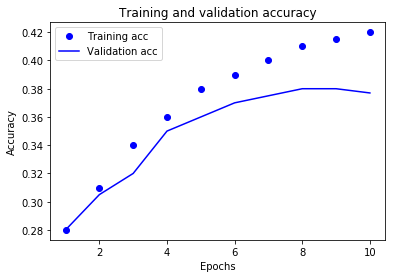

In [79]:
acc(history_dict)

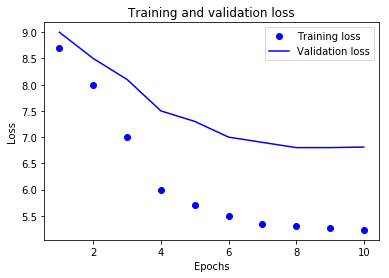

In [80]:
loss(history_dict)

As we can see, model starts to overfit after 8th epoch, so we stop training.

# Testing the solution

In order to test solution you should:
- add "test_annotations.txt" file to test folder
- compile imports
- compile PrepareData class
- run cells below.

Downloading model.

In [ ]:
urllib.request.urlretrieve("http://zfile.in.ua/d/zw9Es/cb547102d8c728db6f12a33eaa53e436/301e168ca53abd5dfe701008c9675a6f", os.path.join("..\\models", "Downloaded_DenseNet-Flatten_Fine-01-0.46.h5"))

In [ ]:
loaded_model = tf.keras.models.load_model("..\\models\\Downloaded_DenseNet-Flatten_Fine-01-0.46.h5")

In [2]:
DATA_PATH = "..\\" + "data"

In [ ]:
PrepareData.prepare_test()

In [79]:
image_size = 64
batch_size = 32

test_datagen = ImageDataGenerator(rescale = 1/255)

test_generator = test_datagen.flow_from_directory(
        DATA_PATH + '/test',
        target_size = (image_size, image_size),
        batch_size = batch_size,
        class_mode = 'categorical'
)

In [80]:
model.evaluate_generator(test_generator)